# Progetto LabIAGI
Paper di riferimento: [*Automatic Differentiation of Damaged
and Unharmed Grapes Using RGB
Images and Convolutional Neural
Networks*](https://drive.google.com/file/d/1d9v5UF6vA_YsOQNSFO_majNa8PQrdUWD/view?usp=sharing) \\
 \\

L'obiettivo principale di questo studio è sviluppare un framework per rilevare automaticamente uve danneggiate nella viticoltura utilizzando immagini RGB e reti neurali convoluzionali (CNN). \\
Si tratta di affrontare, quindi, un problema di _classificazione binaria_.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
from torch.optim import lr_scheduler
import torchvision
import copy
import random
from PIL import Image
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Recupero del materiale e organizzazione delle immagini.

In [ ]:
source_good_1 = "/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_1"
source_good_2 = "/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_1.5"
source_good_3 = "/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_2"
source_bad_1 = "/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_1"
source_bad_2 = "/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_1.5"
source_bad_3 = "/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_2"

In [ ]:
os.makedirs("data", exist_ok=True)
os.makedirs("data/bad", exist_ok=True)
os.makedirs("data/good", exist_ok=True)

# save the images
def save_image(image, name):
    image = image.convert('RGB')
    image = image.resize((300, 300))
    image.save(name)

# load the images
def load_images(name):
    image = Image.open(name)
    data = np.array(image)
    return data

In [ ]:
def saving_bad(folder):
  files = os.listdir(folder)
  for file in files:
      if file.endswith(".jpg"):
          data = load_images(os.path.join(folder, file))
          image_path = os.path.join(folder, file)
          image = Image.open(image_path)
          save_image(image, "data/bad/{}".format(file))


def saving_good(folder):
  files = os.listdir(folder)
  for file in files:
      if file.endswith(".jpg"):
          data = load_images(os.path.join(folder, file))
          image_path = os.path.join(folder, file)
          image = Image.open(image_path)
          save_image(image, "data/good/{}".format(file))

In [ ]:

# saving_bad(source_bad_1)
saving_bad(source_bad_2)
# saving_bad(source_bad_3)


In [ ]:
# saving_good(source_good_1)
# saving_good(source_good_2)
saving_good(source_good_3)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Exploratory Data Analysis
**Target Variable**: riuscire ad appore a ciascuna immagine il corretto label di \\
- "uva non danneggiata" (1) \\
- "uva danneggiata" (0) \\

**Data**: i dati risultano distribuiti in questo modo:
- n. immagini _uva non danneggiata_ -> 193
- n. immagini _uva danneggiata_ -> 580 \\
per un totale di 773 immagini.

In [ ]:
def conta_immagini(nome_cartella, cartella_immagini):
  numero_di_immagini = 0

  for nome_file in os.listdir(cartella_immagini):
      # Controlla se l'estensione del file è una delle estensioni delle immagini
      if nome_file.endswith((".jpg")):
          numero_di_immagini += 1

  print(f"Il numero di immagini nella cartella {nome_cartella} è: {numero_di_immagini}")
  return numero_di_immagini

In [ ]:
def print_image_info(cartella):
    for i, image_name in enumerate(os.listdir(cartella)[:10]):
      percorso = os.path.join(cartella, image_name)
      if percorso.endswith(".jpg"):
        print(f"Caratteristiche per l'immagine {i + 1} della cartella {cartella}:")
        img = cv2.imread(percorso)
        height, width, channels = img.shape
        img_format = os.path.splitext(os.path.basename(percorso))[1]
        color_type = "RGB" if channels == 3 else "Grayscale"

        print(f"Immagine: {percorso}")
        print(f"Dimensioni: {width}x{height} pixels")
        print(f"Formato: {img_format}")
        print(f"Tipo di colore: {color_type}")
        print("=" * 20)
      else:
        print(f"Il file {i + 1} non è un'immagine")


In [ ]:
print("*********** good source ***********")
prova_1 = conta_immagini("scale_1","/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_1")
prova_2 = conta_immagini("scale_1.5", "/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_1.5")
prova_3 = conta_immagini("scale_2","/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_2")
print("*********** bad source ***********")
prova_4 = conta_immagini("scale_1","/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_1")
prova_5 = conta_immagini("scale_1.5", "/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_1.5")
prova_6 = conta_immagini("scale_2","/content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_2")
print("*********** data ***********")
n_cartella_1 = conta_immagini("data/bad","data/bad")
n_cartella_2 = conta_immagini("data/good","/content/data/good")

totale = prova_1 + prova_2 + prova_3
totale2 = prova_4 + prova_5 + prova_6
print(f"Il numero di immagini totale è: {totale}")
print(f"Il numero di immagini totale è: {totale2}")

*********** good source ***********
Il numero di immagini nella cartella scale_1 è: 580
Il numero di immagini nella cartella scale_1.5 è: 290
Il numero di immagini nella cartella scale_2 è: 115
*********** bad source ***********
Il numero di immagini nella cartella scale_1 è: 185
Il numero di immagini nella cartella scale_1.5 è: 108
Il numero di immagini nella cartella scale_2 è: 80
*********** data ***********
Il numero di immagini nella cartella data/bad è: 108
Il numero di immagini nella cartella data/good è: 115
Il numero di immagini totale è: 985
Il numero di immagini totale è: 373


In [ ]:
# Stampare le informazioni sulle prime 10 immagini in ciascuna cartella
# print_image_info(source_good_1)
print_image_info(source_good_2)
# print_image_info(source_good_3)


Caratteristiche per l'immagine 1 della cartella /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_1.5:
Immagine: /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_1.5/IMG_20210924_123645485_0_04.jpg
Dimensioni: 450x450 pixels
Formato: .jpg
Tipo di colore: RGB
Caratteristiche per l'immagine 2 della cartella /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_1.5:
Immagine: /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_1.5/IMG_20210924_155810031_0_01.jpg
Dimensioni: 450x450 pixels
Formato: .jpg
Tipo di colore: RGB
Caratteristiche per l'immagine 3 della cartella /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_1.5:
Immagine: /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/good/scale_1.5/IMG_20210924_121801912_0_01.jpg
Dimensioni: 450x450 pixels
Formato: .jpg
Tipo di colore: RGB
Il file 4 non è un'immagine
Caratteristiche per l'im

In [ ]:
print_image_info(source_bad_1)
print_image_info(source_bad_2)
print_image_info(source_bad_3)


Caratteristiche per l'immagine 1 della cartella /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_1:
Immagine: /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_1/IMG_20210924_155857590_03.jpg
Dimensioni: 300x300 pixels
Formato: .jpg
Tipo di colore: RGB
Il file 2 non è un'immagine
Caratteristiche per l'immagine 3 della cartella /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_1:
Immagine: /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_1/IMG_20210924_131352159_00.jpg
Dimensioni: 300x300 pixels
Formato: .jpg
Tipo di colore: RGB
Caratteristiche per l'immagine 4 della cartella /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_1:
Immagine: /content/drive/MyDrive/supporto_tesi/cropped_patches/first_dataset/bad/scale_1/IMG_20210924_131352159_03.jpg
Dimensioni: 300x300 pixels
Formato: .jpg
Tipo di colore: RGB
Caratteristiche per l'immagine 5 della cartella 

In [ ]:

def stampa_immagine_random(cartella):
    if not os.path.exists(cartella):
        print(f"La cartella '{cartella}' non esiste.")
        return

    lista_immagini = [file for file in os.listdir(cartella) if file.lower().endswith((".jpg", ".jpeg", ".png", ".gif"))]

    if not lista_immagini:
        print(f"Nessuna immagine trovata nella cartella '{cartella}'.")
        return

    immagine_scelta = random.choice(lista_immagini)

    percorso_immagine = os.path.join(cartella, immagine_scelta)

    try:
        print(f"Immagine dalla cartella '{cartella}'.")
        print(percorso_immagine)
        image = Image.open(percorso_immagine)
        plt.imshow(image)
        plt.axis('off')
    except Exception as e:
        print(f"Errore durante l'apertura dell'immagine '{immagine_scelta}': {e}")


Immagine dalla cartella 'data/bad'.
data/bad/IMG_20210924_155857590_00.jpg


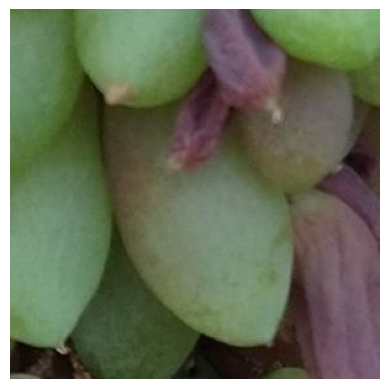

In [ ]:
stampa_immagine_random("data/bad")

Immagine dalla cartella 'data/good'.
data/good/IMG_20210924_124235019_0_00.jpg


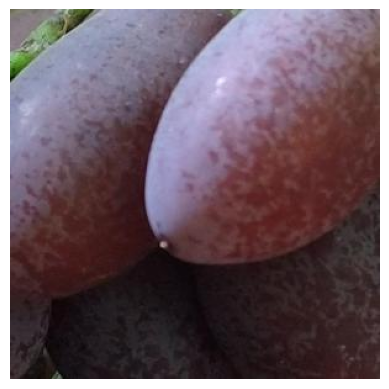

In [ ]:
stampa_immagine_random("data/good")

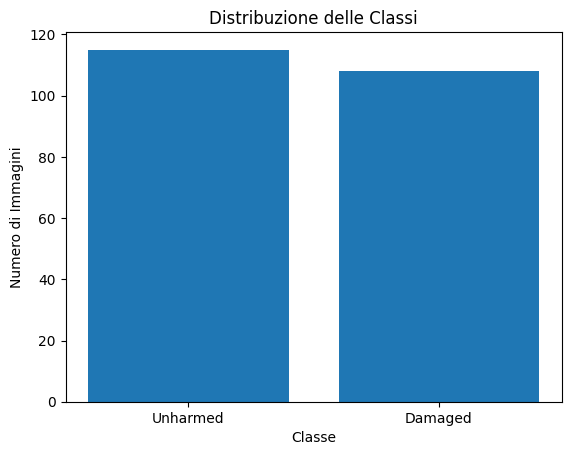

In [ ]:
good_folder = "data/good"
bad_folder = "data/bad"

# Numero di immagini in ciascuna classe
num_good_images = len(os.listdir(good_folder))
num_bad_images = len(os.listdir(bad_folder))

# Creare il grafico a barre
labels = ['Unharmed', 'Damaged']
counts = [num_good_images, num_bad_images]
plt.bar(labels, counts)
plt.xlabel('Classe')
plt.ylabel('Numero di Immagini')
plt.title('Distribuzione delle Classi')
plt.show()


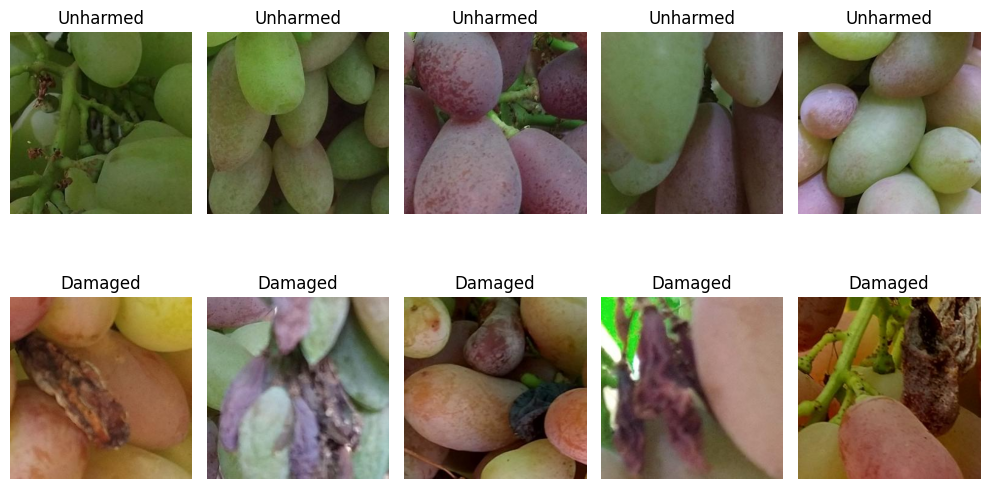

In [ ]:
num_samples = 5

good_samples = os.listdir(good_folder)[:num_samples]
bad_samples = os.listdir(bad_folder)[:num_samples]

fig, axes = plt.subplots(2, num_samples, figsize=(10, 6))

for i in range(num_samples):
    img_good = mpimg.imread(os.path.join(good_folder, good_samples[i]))
    img_bad = mpimg.imread(os.path.join(bad_folder, bad_samples[i]))

    axes[0, i].imshow(img_good)
    axes[0, i].set_title('Unharmed')
    axes[0, i].axis('off')

    axes[1, i].imshow(img_bad)
    axes[1, i].set_title('Damaged')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def custom_image_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform, target_transform=None, loader=custom_image_loader):
        super(CustomImageFolder, self).__init__(root, transform=transform, target_transform=target_transform, loader=loader)


        for idx, (path, _) in enumerate(self.samples):
            # Imposta l'etichetta in base al percorso della directory (0 per 'data/bad' e 1 per 'data/good')
            target = 0 if 'data/bad' in path else 1
            self.samples[idx] = (path, target)


    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)


        if self.target_transform is not None:
            target = self.target_transform(target)


        return sample, target

    def __getpath__(self, index):
        for idx, (path, _) in enumerate(self.samples):
          if idx == index:
              return path

data_dir = 'data'


Per aumentare l'accuratezza del modello, ho applicato *data augmentation*, ribaltando le immagini e concatenando i dataset.

In [ ]:
from torchvision import transforms

data_transform_1 = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),  # Trasforma l'immagine in un tensore prima di normalizzarla
    transforms.RandomHorizontalFlip(p=1)
])

data_transform_2 = transforms.Compose([
    transforms.ToTensor(),  # Trasforma l'immagine in un tensore prima di normalizzarla
    transforms.Resize((100, 100)),
])

dataset_1 = CustomImageFolder(data_dir, transform=data_transform_1)
dataset_2 = CustomImageFolder(data_dir, transform=data_transform_2)

dataset = ConcatDataset([dataset_1, dataset_2])


In [ ]:
from torch.utils.data import random_split

# Percentuale di dati da assegnare all'insieme di test
test_size = 0.15
val_size = 0.35
train_size = 0.50

dataset_size = len(dataset)
print(len(dataset))

train_dataset, test_dataset, validation_dataset= random_split(dataset, [train_size, test_size, val_size])
print(len(train_dataset))
print(len(test_dataset))
print(len(validation_dataset))
# print(len(train_dataset) + len(test_dataset))


446
224
66
156


# Scelta degli iperparametri

In [ ]:
batch_size = 32
num_classes = 2
learning_rate = 0.001
num_epochs = 300

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

print(len(train_loader))
print(len(test_loader))
print(len(validation_loader))



7
3
5


# Definizione del modello

In [ ]:
class ModifiedLeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size = 5 , stride=2, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 5 , stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(576, 32)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out


In [ ]:
model = ModifiedLeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = optim.SGD(model.parameters(), lr=learning_rate,  momentum = 0.001, weight_decay=0.001)

total_step = len(train_loader)

In [ ]:
model.to('cuda')

ModifiedLeNet5(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=576, out_features=32, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
total_step = len(train_loader)
train_losses = []
validation_losses = []


for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if (i+1) % 7 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    train_losses.append(total_loss / len(train_loader))

    total_loss = 0

    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = cost(outputs, labels)
        total_loss += loss.item()

    validation_losses.append(total_loss / len(validation_loader))




Epoch [1/300], Step [7/7], Loss: 0.6915
Epoch [2/300], Step [7/7], Loss: 0.6835
Epoch [3/300], Step [7/7], Loss: 0.6945
Epoch [4/300], Step [7/7], Loss: 0.6876
Epoch [5/300], Step [7/7], Loss: 0.6814
Epoch [6/300], Step [7/7], Loss: 0.6822
Epoch [7/300], Step [7/7], Loss: 0.7019
Epoch [8/300], Step [7/7], Loss: 0.6918
Epoch [9/300], Step [7/7], Loss: 0.6912
Epoch [10/300], Step [7/7], Loss: 0.6757
Epoch [11/300], Step [7/7], Loss: 0.7013
Epoch [12/300], Step [7/7], Loss: 0.6859
Epoch [13/300], Step [7/7], Loss: 0.6927
Epoch [14/300], Step [7/7], Loss: 0.6852
Epoch [15/300], Step [7/7], Loss: 0.6872
Epoch [16/300], Step [7/7], Loss: 0.6961
Epoch [17/300], Step [7/7], Loss: 0.6778
Epoch [18/300], Step [7/7], Loss: 0.6742
Epoch [19/300], Step [7/7], Loss: 0.6838
Epoch [20/300], Step [7/7], Loss: 0.6739
Epoch [21/300], Step [7/7], Loss: 0.6757
Epoch [22/300], Step [7/7], Loss: 0.6899
Epoch [23/300], Step [7/7], Loss: 0.6817
Epoch [24/300], Step [7/7], Loss: 0.6756
Epoch [25/300], Step [7/7

In [ ]:
def compute_accuracy(loader_name, loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print('Accuracy of the network on the {}: {} %'.format(loader_name, accuracy))
        return accuracy

In [ ]:
test_acc = compute_accuracy("test loader", test_loader)
train_acc = compute_accuracy("train loader", train_loader)
val_acc = compute_accuracy("validation loader", validation_loader)


Accuracy of the network on the test loader: 83.33333333333333 %
Accuracy of the network on the train loader: 90.17857142857143 %
Accuracy of the network on the validation loader: 74.35897435897436 %


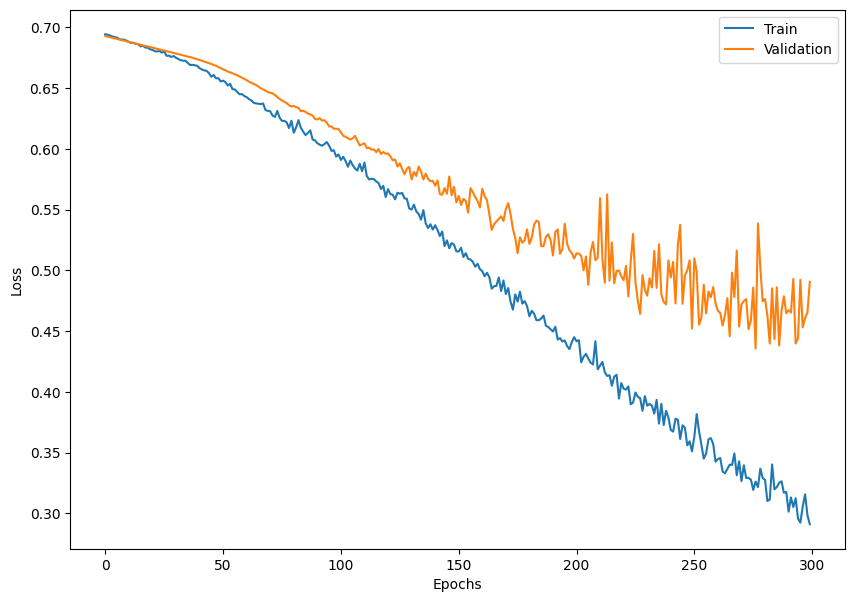

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Train')
plt.plot(validation_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Metriche utilizzate
- *Accuracy*: Misura la percentuale di previsioni corrette rispetto al totale delle previsioni;

- *Precision*: Indica la percentuale di previsioni positive corrette rispetto al totale delle previsioni positive;

- *Recall*: Indica la percentuale di casi positivi corretti rispetto al totale dei casi positivi reali;

- *F1-Score*: È una media armonica tra precisione e recupero ed è utile quando vuoi bilanciare la trade-off tra queste due metriche;

- *ROC-AUC*: Misura la capacità del modello di discriminare tra le classi e valuta la performance complessiva del modello;

- *Matrice di Confusione*: Fornisce una panoramica dettagliata delle previsioni del modello, inclusi i falsi positivi, i falsi negativi, i veri positivi e i veri negativi.


In [ ]:
y_true = []
y_pred = []

model.eval()


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy: 0.8484848484848485
Precision: 0.875
Recall: 0.8235294117647058
F1 Score: 0.8484848484848485


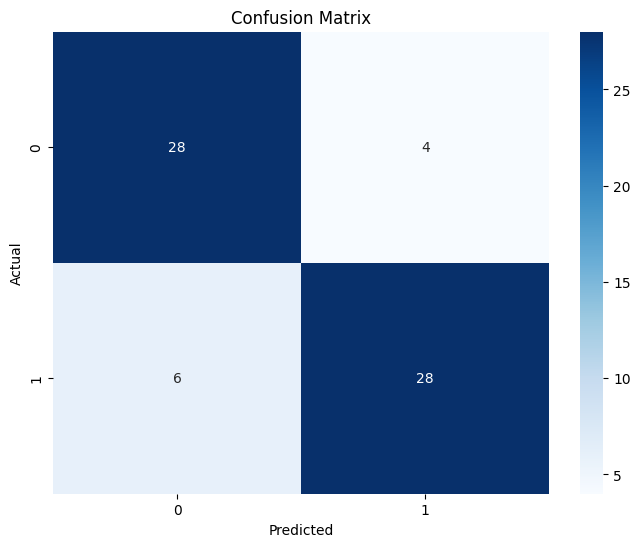

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


conf_matrix = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_true = []
y_score = []

model.eval()


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        positive_probabilities = probabilities[:, 1]

        y_true.extend(labels.cpu().numpy())
        y_score.extend(positive_probabilities.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


66


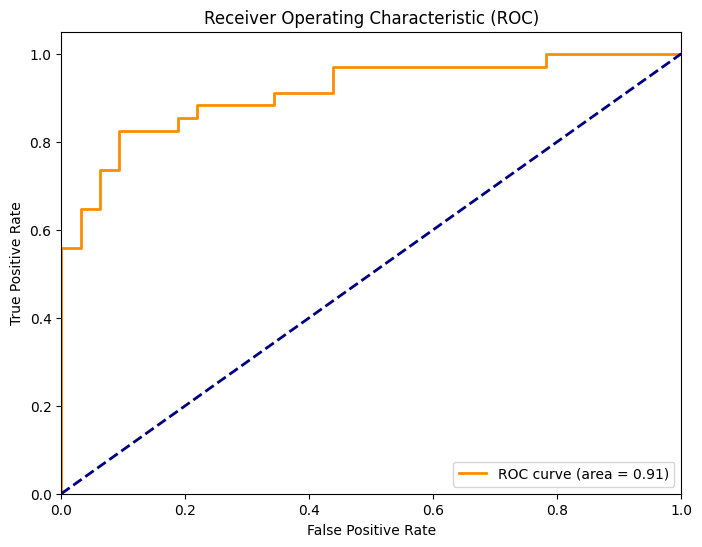

In [ ]:

print(len(y_true))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
